<a href="https://colab.research.google.com/github/DavidRiemer02/DataMiningProj/blob/main/DataMiningProj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark import SparkContext, SparkConf
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, HashingTF, IDF, OneHotEncoder, StringIndexer, VectorAssembler, Tokenizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.functions import col
from pyspark.sql.types import *



import matplotlib.pyplot as plt

import gensim, logging
from gensim.models import Word2Vec

from sklearn.decomposition import PCA

Initialize spark context

In [3]:
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()
sqlContext = SQLContext(spark)

c:\Users\corie\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


# Prepare the Data

Read in the data

In [4]:
train = spark.read.csv('Data/train.csv', header=True, inferSchema=True)
test = spark.read.csv('Data/test.csv', header=True, inferSchema=True)

In [5]:
train.printSchema()
train.show(10)

root
 |-- ItemID: integer (nullable = true)
 |-- Sentiment: integer (nullable = true)
 |-- SentimentText: string (nullable = true)

+------+---------+--------------------+
|ItemID|Sentiment|       SentimentText|
+------+---------+--------------------+
|     1|        0|                 ...|
|     2|        0|                 ...|
|     3|        1|              omg...|
|     4|        0|          .. Omga...|
|     5|        0|         i think ...|
|     6|        0|         or i jus...|
|     7|        1|       Juuuuuuuuu...|
|     8|        0|       Sunny Agai...|
|     9|        1|      handed in m...|
|    10|        1|      hmmmm.... i...|
+------+---------+--------------------+
only showing top 10 rows



Sentiment Count

+---------+-----+
|Sentiment|count|
+---------+-----+
|        1|56462|
|        0|43538|
+---------+-----+



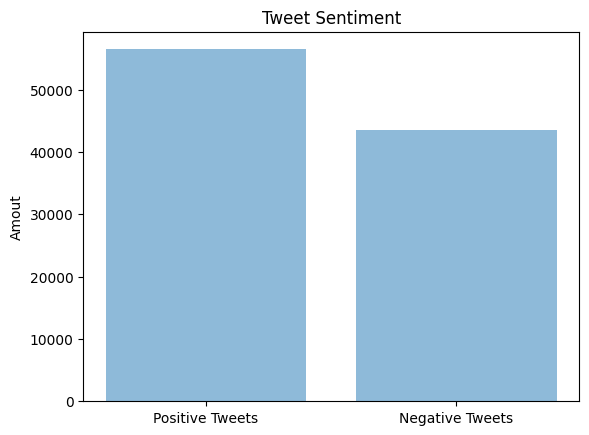

In [11]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# get the count of each sentiment
train.groupBy("Sentiment").count().orderBy(col("count").desc()).show()

noPosTweets = train.groupBy("Sentiment").count().orderBy(col("count").desc()).collect()[0][1]
noNegTweets = train.groupBy("Sentiment").count().orderBy(col("count").desc()).collect()[1][1]

objects = ('Positive Tweets', 'Negative Tweets')
y_pos=(np.arange(len(objects)))
performance = (noPosTweets, noNegTweets)
plt.bar(objects, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Amout')
plt.title('Tweet Sentiment')
plt.show()


Remove stopwords we do not need from the train data \\
Transform the tweets into vectors of words

In [20]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, HashingTF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.sql.types import IntegerType

# Add a column with just words
regexTokenizer = RegexTokenizer(inputCol="SentimentText", outputCol="words", pattern="\\W")

# Remove the stop words
stopwordsRemover = StopWordsRemover(inputCol=regexTokenizer.getOutputCol(), outputCol="filtered")

#converts words into numerical values
hashingTF = HashingTF(inputCol=stopwordsRemover.getOutputCol(), outputCol="features")

pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, hashingTF]).fit(train)

dataset = pipeline.transform(train).select("Sentiment", "filtered", "features")
dataset = dataset.withColumn("Sentiment", dataset["Sentiment"].cast(IntegerType()))

dataset.show(truncate=False, n=5)

+---------+-----------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Sentiment|filtered                                                                                       |features                                                                                                                                                                   |
+---------+-----------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0        |[sad, apl, friend]                                                                             |(262144,[74520,74989,125638],[1.0,1.0,1.0])          

#Run Algorithms on the data

##Run Clustering-algorithms to find smiliar words

In [13]:
import gensim, logging
from gensim.models import Word2Vec

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
#Collect the sentences from the dataframe to a list of lists
sentences = dataset.select("filtered").rdd.flatMap(lambda x: x).collect()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 44.0 failed 1 times, most recent failure: Lost task 2.0 in stage 44.0 (TID 48) (DavidsRazerBook executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1623)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:699)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:743)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:690)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:655)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:631)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:588)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:546)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 17 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1046)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1045)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:195)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:578)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1623)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:699)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:743)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:690)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:655)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:631)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:588)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:546)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 17 more


In [17]:
# train word2vec on the two sentences
model = gensim.models.Word2Vec(sentences, min_count=1)
model = Word2Vec(sentences, vector_size=20, min_count=100)

TypeError: The corpus_iterable must be an iterable of lists of strings, got <function sentences at 0x000002D9345FCE00> instead

In [83]:
model.wv.most_similar("happy")

[('loving', 0.8166717886924744),
 ('germany', 0.8000673055648804),
 ('hows', 0.7979172468185425),
 ('x', 0.7811189293861389),
 ('enjoying', 0.777660608291626),
 ('lady', 0.772476315498352),
 ('excited', 0.7675234079360962),
 ('yay', 0.7643248438835144),
 ('missing', 0.7639089822769165),
 ('sweet', 0.7527605295181274)]

In [111]:
# fit a 2d PCA model to the vectors
vectors = model.wv[model.wv.key_to_index]
wordsArray = list(model.wv.key_to_index)
pca = PCA(n_components=2)
PCA_result = pca.fit_transform(vectors)

# prepare a dataframe
words = pd.DataFrame(wordsArray)
PCA_result = pd.DataFrame(PCA_result)
PCA_result['x_values'] =PCA_result.iloc[0:, 0]
PCA_result['y_values'] =PCA_result.iloc[0:, 1]
PCA_final = pd.merge(words, PCA_result, left_index=True, right_index=True)
PCA_final['word'] =PCA_final.iloc[0:, 0]
PCA_data_labeled =PCA_final[['word','x_values','y_values']]

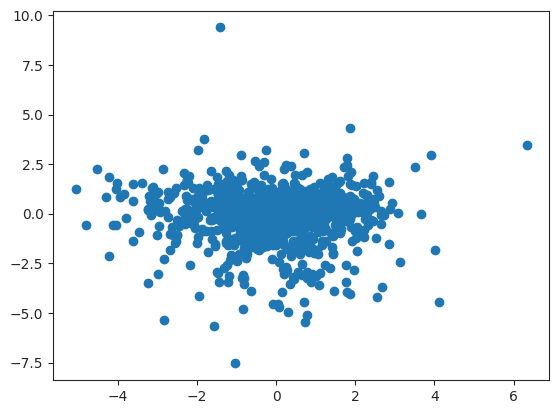

In [118]:
fig = plt.figure()
#zoom out of the graph to see the words more clearly
fig.set_figheight(50)
fig.set_figwidth(50)
ax = fig.add_subplot(1, 1, 1)
#label the points with their respective words
for word, x, y in zip(PCA_data_labeled['word'], PCA_data_labeled['x_values'], PCA_data_labeled['y_values']):
    ax.annotate(word, (x, y))

ax.scatter(PCA_data_labeled['x_values'], PCA_data_labeled['y_values'])

#Run k-means and color the the points in the graph to their respective cluster
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(vectors)
y_kmeans = kmeans.predict(vectors)
ax.scatter(vectors[:, 0], vectors[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

##Run A-propri on the word vetors, to see which words are most often used together

In [14]:
from pyspark.ml.fpm import FPGrowth
apriori = dataset.withColumn("wordsWithoutDupes", array_distinct("filtered"))
fpGrowth = FPGrowth(itemsCol="wordsWithoutDupes", minSupport=0.01, minConfidence=0.4)
model = fpGrowth.fit(apriori)

NameError: name 'array_distinct' is not defined

In [ ]:
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.functions import desc
apriori_model.freqItemsets.sort(desc("freq")).show(apriori_model.freqItemsets.count())
print("Number of frequent itemsets: " + str(model.freqItemsets.count()))
model.associationRules.show(5)
print("Number of association rules: " + str(model.associationRules.count()))

+---------+----+
|    items|freq|
+---------+----+
|   [wait]|1218|
|   [more]|2112|
|[more, i]|1089|
|  [thing]|1054|
|   [come]|1664|
+---------+----+
only showing top 5 rows

Number of frequent itemsets: 718
+----------+----------+-------------------+------------------+-------+
|antecedent|consequent|         confidence|              lift|support|
+----------+----------+-------------------+------------------+-------+
|  [was, a]|       [i]| 0.6230337078651685|1.3956223015661677|0.01109|
|    [here]|       [i]|0.49673469387755104| 1.112707078261617|0.01217|
|  [me, it]|       [i]| 0.5881294964028777|1.3174353667014869|0.01308|
|   [it, a]|       [i]|  0.572563331902104|1.2825664887372967|0.02667|
|     [you]|       [i]| 0.4640354112873478| 1.039459278901814|0.11322|
+----------+----------+-------------------+------------------+-------+
only showing top 5 rows

Number of association rules: 260


##Train the model to predict Sentiment on the test data

In [2]:
#Split training and Testing
split_data=train.randomSplit([0.7,0.3])
trainSplit=split_data[0]

#label in test renamed to true label
testSplit=split_data[1]

trainSplit = pipeline.transform(trainSplit).select("Sentiment", "filtered", "features")
testSplit = pipeline.transform(testSplit).select("Sentiment", "filtered", "features")

#Count the number of training tweets and testing tweets
print("Number of training tweets: " + str(trainSplit.count()))
print("Number of testing tweets: " + str(testSplit.count()))

trainSplit.show(5, truncate=False)
testSplit.show(5, truncate=False)

NameError: name 'train' is not defined

In [35]:
lr = LogisticRegression(labelCol = 'Sentiment', featuresCol='features', maxIter=50, regParam=0.01)
lrModel = lr.fit(trainSplit)
print("Done")

raw_prediction = lrModel.transform(testSplit)
raw_prediction.printSchema()

Done
root
 |-- Sentiment: integer (nullable = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [36]:
Final_prediction = raw_prediction.select("filtered", "prediction", "Sentiment")
Final_prediction.show(n=4, truncate = False)

+------------------------------------+----------+---------+
|filtered                            |prediction|Sentiment|
+------------------------------------+----------+---------+
|[omg, already, 7, 30, o]            |0.0       |1        |
|[think, mi, bf, cheating, t_t]      |0.0       |0        |
|[juuuuuuuuuuuuuuuuussssst, chillin] |1.0       |1        |
|[sunny, work, tomorrow, tv, tonight]|0.0       |0        |
+------------------------------------+----------+---------+
only showing top 4 rows



In [1]:
#Count the accuracy
correctPrediction = Final_prediction.filter(Final_prediction['prediction'] == Final_prediction['Sentiment']).count()
print("Number of correct predictions: " + str(correctPrediction))
Accuracy = correctPrediction/testSplit.count()*100
print("Accuracy: " + str(Accuracy))


NameError: name 'Final_prediction' is not defined